# IMPORTS

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


import numpy as np
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import numpy as np
from keras.models import Model, Sequential
from keras.layers import SpatialDropout1D, Bidirectional, Dense, Embedding, Activation, Input
from keras.layers import GRU, LSTM, Convolution1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [83]:
#Pretrained word embeddings (fasttext)
EMBEDDING_FILE = 'crawl-300d-2M.vec'

In [134]:
train = pd.read_csv('toxic_train.csv',index_col = 'id').fillna(' ')
test = pd.read_csv('toxic_test.csv',index_col = 'id').fillna(' ')
uber = pd.read_csv('allubertweets.csv',index_col = 'id').fillna(' ')

In [4]:
train["comment_text"].fillna("fillna")
test["comment_text"].fillna("fillna")
X_train = train["comment_text"].str.lower()
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

X_test = test["comment_text"].str.lower()

## TWEETS CLEANING

In [140]:
Uber_test.head()

id
9.711829e+17     uber support hi   payment for my family membe...
9.711829e+17     morganlondonn  bill football  uber support  u...
9.711829e+17     mrbobbybones your imaginary friend being a le...
9.711828e+17                                 uber be so expensive
9.711828e+17    so i came in my uber driver car high asf and h...
Name: text, dtype: object

In [138]:
Uber_test = uber['text'].str.lower()

In [141]:
Uber_test = tok.texts_to_sequences(Uber_test)
uber_test = sequence.pad_sequences(Uber_test,maxlen=maxlen)

## Time to use NN

In [61]:
#Add ROC-AUC score to each epoch callback
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))


In [6]:
#Tokenize so text can be used with pretrained embeddings
tok=text.Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(list(X_train)+list(X_test))

X_train=tok.texts_to_sequences(X_train)
X_test=tok.texts_to_sequences(X_test)
x_train=sequence.pad_sequences(X_train,maxlen=maxlen)
x_test=sequence.pad_sequences(X_test,maxlen=maxlen)

In [5]:
#Establishing NN parameters
max_features=100000
maxlen=150
embed_size=300

In [85]:
#Implementing fasttext embeddings
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

word_index = tok.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector


In [119]:
#Initially tested with just LSTM and dropout, then found bidirectional GRU performed better.  
#Convolution layer was added after the RNN with pooling to prevent overfitting
sequence_input = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(100, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Convolution1D(50, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 

preds = Dense(6, activation="sigmoid")(x)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

In [120]:
batch_size = 128
epochs = 4

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=42)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [121]:
model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks = [RocAuc])

Train on 143613 samples, validate on 15958 samples
Epoch 1/4
143488/143613 [============================>.] - ETA: 1s - loss: 0.0590 - acc: 0.9796
 ROC-AUC - epoch: 1 - score: 0.985482 

143613/143613 [==============================] - 1772s 12ms/step - loss: 0.0590 - acc: 0.9796 - val_loss: 0.0427 - val_acc: 0.9837
Epoch 2/4
143488/143613 [============================>.] - ETA: 1s - loss: 0.0444 - acc: 0.9831
 ROC-AUC - epoch: 2 - score: 0.988340 

143613/143613 [==============================] - 1763s 12ms/step - loss: 0.0445 - acc: 0.9831 - val_loss: 0.0409 - val_acc: 0.9842
Epoch 3/4
143488/143613 [============================>.] - ETA: 1s - loss: 0.0417 - acc: 0.9839
 ROC-AUC - epoch: 3 - score: 0.988939 

143613/143613 [==============================] - 1760s 12ms/step - loss: 0.0417 - acc: 0.9839 - val_loss: 0.0403 - val_acc: 0.9845
Epoch 4/4
143488/143613 [============================>.] - ETA: 1s - loss: 0.0398 - acc: 0.9846
 ROC-AUC - epoch: 4 - score: 0.989314 

143613/14361

In [142]:
predictions = model.predict(uber_test, batch_size = 1000, verbose = 1)

25063/25063 [==============================] - 50s 2ms/step


In [123]:
submission = pd.read_csv('sample_submission.csv')

In [124]:

submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = predictions
#submission.to_csv('submission.csv', index=False)

In [128]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.995864,0.559030,0.988308,0.067331,0.960464,0.755773
1,0000247867823ef7,0.001140,0.000031,0.000261,0.000025,0.000235,0.000079
2,00013b17ad220c46,0.000512,0.000076,0.000124,0.000042,0.000242,0.000050
3,00017563c3f7919a,0.000496,0.000018,0.000233,0.000052,0.000213,0.000035
4,00017695ad8997eb,0.008337,0.000213,0.000907,0.000126,0.000955,0.000063


In [126]:
submission.to_csv('nn_conv_submission.csv', index=False)

## Using the NN on uber tweets

In [144]:
uberpreds = uber.copy()

In [148]:
predictions.shape

(25063, 6)

In [145]:
uberpreds['toxic'] = np.zeros
uberpreds['severe_toxic'] = np.zeros
uberpreds['obscene'] = np.zeros
uberpreds['threat'] = np.zeros
uberpreds['insult'] = np.zeros
uberpreds['identity_hate'] = np.zeros

In [149]:
uberpreds[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = predictions

In [150]:
uberpreds.head()

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
9.711829e+17,Uber Support Hi payment for my family membe...,0.000973144,2.11599e-05,8.55581e-05,1.31823e-05,0.000122775,4.17909e-05
9.711829e+17,MorganLondonn bill football Uber Support U...,0.0120712,9.21329e-05,0.000522501,5.04814e-05,0.00247271,0.000154786
9.711829e+17,mrBobbyBones Your imaginary friend being a le...,0.801107,0.00291072,0.153961,0.000292372,0.11712,0.00202786
9.711828e+17,Uber be so expensive,0.0854548,0.000686277,0.00739089,0.000800249,0.021527,0.00194735
9.711828e+17,SO i came in my uber driver car HIGH ASF and h...,0.0656527,0.00226269,0.0265541,0.000321724,0.0161449,0.0111967


### Simplifying this test, if a comment is classified above 0.5, it is considered that category of toxic 

In [155]:
uberpreds['toxic'] = uberpreds['toxic'].apply(lambda row: 1 if float(row) >= 0.5 else 0)
uberpreds['severe_toxic'] = uberpreds['severe_toxic'].apply(lambda row: 1 if float(row) >= 0.5 else 0)
uberpreds['obscene'] = uberpreds['obscene'].apply(lambda row: 1 if float(row) >= 0.5 else 0)
uberpreds['threat'] = uberpreds['threat'].apply(lambda row: 1 if float(row) >= 0.5 else 0)
uberpreds['insult'] = uberpreds['insult'].apply(lambda row: 1 if float(row) >= 0.5 else 0)
uberpreds['identity_hate'] = uberpreds['identity_hate'].apply(lambda row: 1 if float(row) >= 0.5 else 0)

In [176]:
uberpreds['clean'] = uberpreds['toxic'].apply(lambda row: 1 if row == 0 else 0)

In [174]:
uberpreds.text[uberpreds.toxic == 0]

id
9.711829e+17     Uber Support Hi   payment for my family membe...
9.711829e+17     MorganLondonn  bill football  Uber Support  U...
9.711828e+17                                 Uber be so expensive
9.711828e+17    SO i came in my uber driver car HIGH ASF and h...
9.711828e+17     DaniNicole   Idek what an uber pool is sorry ...
9.711827e+17    Walking around Providence and need a taxi  Get...
9.711827e+17    Uber driver is blaring Oliver Tree  which I ve...
9.711827e+17     madisonnn l Ya know    I woke up way too late...
9.711827e+17     aficado Uber eats booking fee is waaaaaay to ...
9.711827e+17     K sbruce  Uber How long ago did you message t...
9.711826e+17    Uber drivers often make below minimum wage  re...
9.711826e+17     bloodymasa What a free ride use my promo code...
9.711826e+17                             Don t fail me uber eats 
9.711825e+17            Uber eats been keepin my head above water
9.711825e+17     techreview  mcdickenson  BankofAmerica  Unile...
9.71182

In [172]:
[print(x,"\n##########") for x in uberpreds.text[uberpreds.insult == 1]]

Tens of thousands of fucking morons sending       per text message to save a D List shithead on  reality  show  I m A Celebrity    Get Me Out Of Here   and I can t even get my friends  useless idiots  to split an Uber for my own reality   I m A Shit Faced Mess  Get Me Home   
##########
Shawty don t know me I m petty  amp  nasty idgaf  I get dropped off first so her and that rude ass Uber driver can suffer 
##########
 Uber ONE OF YOUR DRIVERS FUCKING SCREWED ME AND WILL NOT BE FUCKING GETTING AWAY WITH IT 
##########
 Upraisefn Well if yougotthat text from your actual Uber driver then the guy driving you is some random ass nigga  sothe statement that  your Uber driver picked you up   minutes ago would be incorrect making this whole scenario defying logic because a random nigga would be texting u instead 
##########
This uber driver is pissing me off like nigga just drive and stfu 
##########
This uber warm as a bitch 
##########
fuck uber rides alone 
##########
I need my Uber driver 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [173]:
[print(x,"\n##########") for x in uberpreds.text[uberpreds.toxic == 0]]

 Uber Support Hi   payment for my family members is frequently declined  I m not the only one with this issue   what s the fix  
##########
 MorganLondonn  bill football  Uber Support  Uber  UberUKsupport At least they re cheap though  eh  
##########
Uber be so expensive 
##########
SO i came in my uber driver car HIGH ASF and he was like yall should of brought me some plugs bd LMFAOOO 
##########
 DaniNicole   Idek what an uber pool is sorry i have a car 
##########
Walking around Providence and need a taxi  Get    free rides w  Lyft Promo Code  OATH  limo  cab  Lyft  uber   Rolling Offers for You 
##########
Uber driver is blaring Oliver Tree  which I ve never heard until now  And I m like 
##########
 madisonnn l Ya know    I woke up way too late and had to take an Uber pool 
##########
 aficado Uber eats booking fee is waaaaaay to much money   
##########
 K sbruce  Uber How long ago did you message them  I was charged double once and I didn t get a message from Uber till the very

Let s HEAD TO THE  BAR   FREE  Lyft code  SCOTT      promocode  ridershare  uber 
##########
Uber Celebrates  Driven Women  in Asia for International Women s Day  Uber 
##########
when will my five star uber arrive 
##########
Free taxi fares to Brasserie Les Halles this month  Lyft credit code IBEX gives     in free rides to top uber promo  GetARide   ad High five for free rides  
##########
North Korea is open to getting rid of its nukes  Chanel chops down trees for  fashion   and Uber self drives your Kindle  SKYNET and the age of the terminator looms large   dailymaverick First Thing  
##########
Uber   Sign up to ride 
##########
Get money back every time you go to the grocery store  Walmart  drug store  liquor store  take an uber ride  and many more stores and online stores as well no credit card info needed  great bonus for signing up ii 
##########
Uber s self driving trucks are now delivering freight in Arizona  Uber  smartcars  innovation  technology  autonomous  tech 
######

Me to the uber driver when          plays  can you change to my aux cord  
##########
The future is closer than you think   Tech  Auto  Uber 
##########
Uber s Idea Of Team Bonding Is Sitting Through A Play About All The Embarrassments The Company Suffered 
##########
Need a cab freebie Pittsburgh  The GUESTS credit code on Lyft beats any Uber code for free credit  Total truth   ad High five for free rides  
##########
 startup Uber may be planning to work with Waymo  uber 
##########
 startup Uber s underpayment of drivers keeping it afloat  report finds  uber 
##########
 startup Uber s self driving trucks are making deliveries in Arizona  uber 
##########
 startup Uber s self driving trucks begin hauling freight in Arizona  uber 
##########
Uber s self driving truck plan relies heavily on humans via  techreview 
##########
 startup Uber and Lyft Drivers Are Probably Making More Than       an Hour  But That s a Real Low Bar  uber 
##########
Uber marks International Women s Day with 

##########
Need free Lyft rides  We ll show you how Special Lyft Code MINX     Kay County  Oklahoma   Lyft  gt  Uber 
##########
New post  I m an Uber Customer Service Associate and I ve Been on the Phone with Clint Eastwood for   Years  has been published on JoRoNoMo   
##########
Try Lyft cabs free Louisville  Uber clone Lyft plays hardball with code FASTEST for    dollars of free ride  Rad solid  Sick deal  
##########
Uber s  flying cars  could arrive by      
##########
Uber spent       bn in nine years  Here s where it went  india  indiabiz 
##########
Want a free ride to Darrell K Royal Texas Memorial Stadium   Go w  Lyft       Lyft credit for new users w  Promo CODE CLEO  freeLyft  Lyft  stadium  uber   Credit may be different based on where you re located 
##########
I added a video to a  YouTube playlist Uber s flying cars 
##########
god bless my phone was at    when i got off the train and called my uber  and he had a charger at the ready for me 
##########
Seem like the Ub

 Uber Support Now you wanna give me the trouble of logging in to my account  Convenient support options i guess  
##########
 uber      someone more talented than me needs to write a Ted in Bed saga Dr  Seuss style 
##########
 nowthisnews Although Uber is capitalism to its core  Theres no denying its convenient technological platform  Taxi and it s drivers need to reevaluate itself  and keep up with the fast pace user friendly environment  Wages and fees is a whole diff monster tho  
##########
 nowthisnews Your protected industry is dying like it should  Get on board with Uber 
##########
In Japan i can pass for     but last night my uber driver stopped me before getting into the car and asked if I was really over    
##########
Uber everywhere 
##########
Can everyone in the world just send my mom like an uber amount of prayers please  
##########
NO  Ladies please don t try to invite yourself to my crib in attempt to get snowed in with me RT  NaughtyByNatur   Bet RT  ODAT   This is

via  BreitbartNews Uber Buys Half the Tickets to Theater Show Inspired by Company s Scandals  tcot 
##########
Uber Buys Half the Tickets to Theater Show Inspired by Company s Scandals 
##########
Uber Buys Half the Tickets to Theater Show Inspired by Company s Scandals via  BreitbartNews 
##########
Uber for pronunciation 
##########
San Francisco News Mission District cabbie attacks self driving car   Curbed SF 
##########
 AmyBowBamy Here to help  Send us a DM with your email address so we can assist  
##########
 Uber offers providers  patients new Uber Health transportation app and dashboard via  HC Finance  healthcare  mHealth 
##########
I liked a  YouTube video Extreme UBER DRIVER PRANK 
##########
Plentix will give customers like Uber and others  small or large  the opportunity to transform their marketing and sales  and also the international market ecosystem   Plentix  PlentixICO 
##########
 uqure   an uber there costs    ish dollars    
##########
Uber s  flying cars  coul

 mikemcintyrewpg Have you tried the Uber yet  Pretty awesome  Winnipeg needs to get onboard with this  Plus a subway  The subway is amazing eh 
##########
 Uber  lyft  Postmates get off of craigslist and online job boards with your sleazy lies   NOBODY is making     hr driving for you as a misclassified  self employed businessman  
##########
My  Uber drivers car just abruptly dropped off my phone screen  That s not a good thing  right   II     
##########
 Uber Support Hi  just got charged     for a        trip because the driver missed the turning TWICE on the motor way  I hope you get back to me as that s quite frustrating and unlike UBER  Happy to supply details  Thanks  George  
##########
Uber   Sign up to ride 
##########
Me in my Uber going home at  am 
##########
Interested in Agwa de Bolivia    herbs   Use this code to get free Lyfts BEG   Lyft  gt  Uber 
##########
Researcher Admits Study That Claimed Uber Drivers Earn       an Hour Was Not Correct via  FortuneMagazine 
####

##########
 zach young    lauraashleyt You re trying to start a rumor  little Taxi hating tool that you are  LOL   Laura  knock yourself out because it s still going to be the same people driving Uber that drive legitimate tax paying Cabs  
##########
Woooow Uber Eats not loyal rn smh 
##########
Her  I need a favor Me  sure   If I can Her  just say yes you ll Me  what is it   Her  my pho      Uber arrives 
##########
 CTRailCommuters What does  MetroNorth do to help stranded passengers  Do they reimburse for Uber or lyft rides  
##########
 Taxify AU I ve just received an email saying you are going to begin surge prices   wasn t this your point of difference from  UberAustralia  Very disappointing you have changed your model already  uber  taxify  surgepricing  transport 
##########
Private hire car services  Uber   GrabSG may face regulations and licensing  SGBudget     
##########
  bobes  Uber Amazon does something like that in selected cities  Abq is probably not one 
##########
U

Interested to see how this plays out in Vietnam with Go Jek reportedly planning to enter the market soon  via  technology 
##########
Deal coming this week or next via  yoolimleenews  EricNewcomer via  technology 
##########
Code for free cabs Boston  Big freebie from Lyft with credit code GUESTS  Uber is upset Cool cabs   ad Super freebie code  
##########
Grab Close to Deal for Uber s Southeast Asia Business    
##########
 ingiggswetrust I ll Uber u here 
##########
 Uber Anne  RedheadTrap Cute 
##########
In New York City  New York       Free Lyft ride credit w  Lyft Promo Code PLEX  freeLyft  uber  Lyft   Lyft vs Uber 
##########
 Sindrolik  theresawebbxo      is the year of saving money  WE ARE NOT GETTING UBER EATS 
##########
Get a free fare San Antonio  Use Lyft w credit code GUESTS to save over Uber  Ride credit promo code  Swag deal   ad Great freebie  
##########
 veryaveragejoe   sexualjumanji It s called uber 
##########
Travis Kalanick  the former chief executive officer

Uni trip is still on  and my uber is late  
##########
Via  Reuters  Grab in advanced talks to buy some of Uber s Southeast Asia businesses  source 
##########
My Uber is literally going     rn on the freeway Jesus help me 
##########
Had to cut my Uber off early cause this feminist Uber driver couldn t provide facts about a subject she brought up  
##########
 zurairi  Uber  GrabMY Uber drivers so far little problems  and they will show up  Grab drivers on the other hand  getting very pick with destinations  As much as I d like to support home grown brand  it s the drivers that s failing the brand  amp  platform  
##########
Australia study shows  Uber drivers make less than minimum wage   Business Insider 
##########
Grab in advanced talks to buy some of Uber s Southeast Asia businesses  source 
##########
Grab in advanced talks to buy some of Uber s Southeast Asia businesses  source 
##########
Grab in advanced talks to buy some of Uber s Southeast Asia businesses  source 
#########

Talking to my Uber about Post Malone   Wait you re telling me he s white    
##########
 NJTrainDelays  Uber  NJTRANSIT There is an iPhone version and at first glance it is so much more intuitive  There s a map  
##########
 jrinree We see your DM and a member of our team will be in contact shortly  We appreciate your patience  
##########
I predict a new  World s largest bank  will no have cash or loans   once  blockchain  fintech is more mature  this bank will only link to others for transfers Natural trend of disruptive tech without traditional assets Facebook   media Uber   taxi AirBnB   hotel Amazon   retail 
##########
 GangGreenSports  Uber he gets        plus tip 
##########
 Noahpinion What do you think would make this business model better  while maintaining the ease of getting into it and the flexibility for drivers  I imagine Uber could charge a little more  Right now it s about half cab prices  it could be    rds and still be great  
##########
 HAllisReal Happy to help cl

##########
 Uber offers flexible way to make extra  Income your terms Drive whenever you want  amp  get      today  DriversWanted 
##########
Hey  I hit       star trips on Uber last night  
##########
 Uber Pune booked your cab for emergency the driver called and asked for drop location and cancelled the ride ridiculous 
##########
 Marquette     Here to help  Please send us a direct message with your email address so we can assist  
##########
 Uber Support Please I need to order food 
##########
 Uber I am not getting receipts of my trips  But how come getting all promotional mail   
##########
I m so faded in this uber yo lmao 
##########
 OmarAhm         Thank you for providing this information  Omar  Our team is currently working to resolve this issue and will be in touch shortly via email  We appreciate your patience while we review  
##########
 uber      oh I know  I m surprised the McLaren s electronics are still on 
##########
 Uber Support hey guys  I m trying to set up my 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [162]:
len(uberpreds)

25063

In [179]:
uberpreds = uberpreds[['text','clean','toxic','severe_toxic','obscene','threat','insult','identity_hate']]

In [180]:
uberpreds.head()

,text,clean,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,,
9.711829e+17,Uber Support Hi payment for my family membe...,1,0,0,0,0,0,0
9.711829e+17,MorganLondonn bill football Uber Support U...,1,0,0,0,0,0,0
9.711829e+17,mrBobbyBones Your imaginary friend being a le...,0,1,0,0,0,0,0
9.711828e+17,Uber be so expensive,1,0,0,0,0,0,0
9.711828e+17,SO i came in my uber driver car HIGH ASF and h...,1,0,0,0,0,0,0


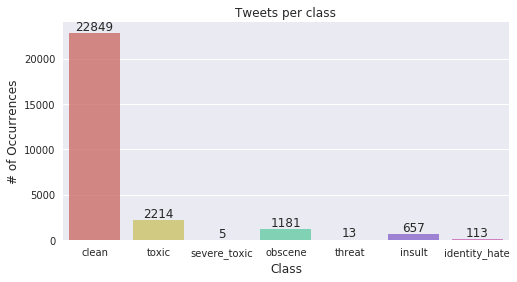

In [183]:
x=uberpreds.iloc[:,1:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8, palette = 'hls')
plt.title("Tweets per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Class', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()